In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy

In [2]:
img = cv2.imread("./data/faces93")


In [3]:
from tqdm import tqdm

image_data = []
photos_path= "./data/faces94"
for folder in os.listdir(photos_path):
    print("going through folders")
    inside_folder_path = os.path.join(photos_path, folder)
    for images_folder in tqdm(os.listdir(inside_folder_path)):
        images_folder_path = os.path.join(inside_folder_path, images_folder)
        for image_file in filter(lambda x: x.endswith("jpg"), os.listdir(images_folder_path)):
            image_file_path = os.path.join(images_folder_path, image_file)
            image = cv2.imread(image_file_path)
            image_data.append({'Filename': image_file_path, 'ImageArray': image})

print("Created the dataframe")

going through folders


100%|██████████| 20/20 [00:01<00:00, 15.96it/s]


going through folders


100%|██████████| 113/113 [00:06<00:00, 18.64it/s]


going through folders


100%|██████████| 20/20 [00:00<00:00, 25.00it/s]

Created the dataframe


In [4]:
images = list(map(lambda item: item["ImageArray"], image_data))
files_path = list(map(lambda item: item["Filename"], image_data))
images = np.array(images)

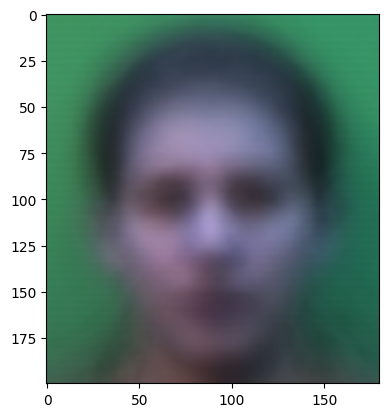

In [5]:
average_image = images.mean(axis=0)
average_image = np.round(average_image)
average_image = average_image.astype(np.uint8)
plt.imshow(average_image)

In [6]:
def show_image(image, gray=False):
    image = image.reshape(images[0].shape)
    image = (image - image.min()) / (image.max() - image.min())
    image = image * 255
    image = image.astype(np.uint8)

    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


In [7]:
images_vectors_raw = images.reshape(images.shape[0], -1)
average_image = images.reshape(images.shape[0],-1).mean(axis=0)
# X = (images - average_image).reshape(images.shape[0], -1)
X = images_vectors_raw - average_image

# both of size (NxD)

In [8]:
N = images.shape[0]

In [9]:
# cov_matrix = np.cov(images_vectors_raw) / N # This doesn't work for some reason???? with or without the division by N......
cov_matrix = (1/N) * X @ X.T


### Transform 

In [10]:
# eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(cov_matrix)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# for k in num_vectors:
    # image = images_vectors_raw[0]
    # image

In [11]:
normalization_factors = np.array([np.sqrt(eigenvalue * N) for eigenvalue in eigenvalues])
# eigenfaces = np.array([np.dot(X.T , eigenvectors)]) /  normalization_factors[:, np.newaxis]
eigenfaces_raw = np.array([np.dot(X.T , eigenvectors)]) # N x K

C:\Users\Ron Tohar\AppData\Local\Temp\ipykernel_9972\3852345211.py:1: RuntimeWarning: invalid value encountered in sqrt
  normalization_factors = np.array([np.sqrt(eigenvalue * N) for eigenvalue in eigenvalues])


In [12]:
eigenfaces_reshaped = np.squeeze(eigenfaces_raw)
eigenfaces_transpose = eigenfaces_reshaped / normalization_factors

In [13]:
eigenfaces = eigenfaces_transpose.T

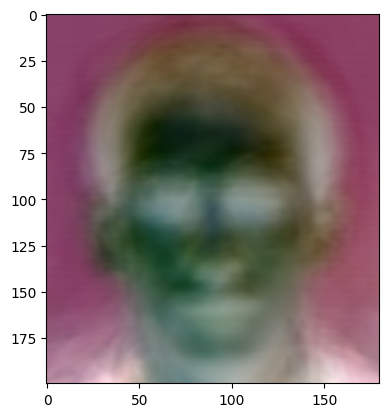

In [18]:
show_image(eigenfaces[0], gray=False)

In [ ]:
# num_vectors = [2,5,10,50,100,300]
num_vectors = [2,5,10,50,100,300,500,1000]

def decompose_with_eigenfaces(x_n, x_avg, eigenfaces):
    coeffs = np.array([(x_n.T @ eigenface) - (x_avg.T @ eigenface) for eigenface in eigenfaces])
    eigenfaces_directions = coeffs[:,np.newaxis] * eigenfaces
    average_image_delta = sum(eigenfaces_directions)
    
    return x_avg  + average_image_delta

images_indices = list(range(0,500,50))
for k in num_vectors:
    curr_eigenfaces = eigenfaces[:k]
    x_n = images_vectors_raw[100]
    x_avg = average_image
    new_image = decompose_with_eigenfaces(x_n, x_avg, curr_eigenfaces)
    show_image(new_image)
    show_image(x_n)


### Define metric with yes or no for similarity and check the number of required eigenfaces for 60% score

In [92]:
similarity_threshold = 0.983
image_shape = images[0].shape

def channel_similarity(img1, img2, c=0):
    img1_values = img1[:,:,c].flatten()
    img3_values = img2[:,:,c].flatten()
    values_diff = img1_values - img3_values
    values_diff = np.abs(values_diff)
    avg_diff = sum(values_diff)/len(values_diff)
    similarity = 1 - (avg_diff / (255))
    # print(values_diff)
    # print(f'Channel {c} similarity: ',similarity)
    return similarity

def image_similarity_score(img1, img2, need_reshape=True):
    if need_reshape:
        img2 = img2.reshape(image_shape)
        img1 = img1.reshape(image_shape)
    return sum([channel_similarity(img1, img2, c) for c in range(3)]) / 3

def is_similar_images(img1, img2, need_reshape=True):
    assert img1.shape == img2.shape, f'Images are not of the same shape {img1.shape} != {img2.shape}'
    return image_similarity_score(img1, img2, need_reshape=need_reshape) > similarity_threshold
    
    

# img1 = images_vectors_raw[100]
# img2 = images_vectors_raw[0]

# image_similarity_score(img1.reshape(image_shape), img2.reshape(image_shape))


In [116]:
from tqdm import tqdm
num_vectors = [100, 200, 225, 250, 275, 300, 310, 320]
images_indices = list(range(0,500,50))
images_samples = images_vectors_raw[images_indices]

similarity_scores = []
for image_sample in tqdm(images_samples):
    for k in tqdm(num_vectors, leave=False):
        curr_eigenfaces = eigenfaces[:k]
        x_avg = average_image
        new_image = decompose_with_eigenfaces(image_sample, x_avg, curr_eigenfaces)
        similarity_score = image_similarity_score(image_sample, new_image, need_reshape=True)
        # print("similarity_score:", similarity_score, " with k = ",k)
        similarity_scores.append((k,similarity_score))

100%|██████████| 10/10 [02:30<00:00, 15.01s/it]


In [117]:
similarity_scores_k = np.array(similarity_scores)[:,0]
similarity_scores_v = np.array(similarity_scores)[:,1]

sorted_indices = np.argsort(similarity_scores_k)
similarity_scores_k = similarity_scores_k[sorted_indices]
similarity_scores_v = similarity_scores_v[sorted_indices]

k_vals = similarity_scores_k.reshape(len(num_vectors),-1)
v_vals = similarity_scores_v.reshape(len(num_vectors),-1)

In [118]:
# num_success = np.apply_along_axis(lambda row: 1, arr=v_vals)
# num_success
k_vals_thin = k_vals[:,0]
similarity_threshold = 0.975
masked_vals = v_vals > similarity_threshold

success_rate = np.sum(masked_vals, axis=1) / np.sum(len(images_samples))
filtered_array = success_rate[success_rate >= 0.6]
minimum_value = np.min(filtered_array)

# Find the index of the minimum value in the original array
minimum_index = np.where(success_rate == minimum_value)[0][0]
lowest_good_k = k_vals_thin[minimum_index]

print(f"Lowest number of eigenfaces to reach 60 percent or more accuracy is {lowest_good_k} eigenfaces")
print("The success rates for each k were\n(k,success_rate)")
print(list(zip(k_vals_thin, success_rate)))

Lowest number of eigenfaces to reach 60 percent or more accuracy is 300.0 eigenfaces
The success rates for each k were
(k,success_rate)
[(100.0, 0.0), (200.0, 0.2), (225.0, 0.3), (250.0, 0.5), (275.0, 0.5), (300.0, 0.6), (310.0, 0.7), (320.0, 0.8)]
